# Estimating CPRS

This notebook estimates [Chronos Bolt](https://github.com/amazon-science/chronos-forecasting)'s zero-shot CRPS on each pretraining dataset. Read [this](https://docs.google.com/document/d/1LsKQ9I4i4xLwhiywDrFUkeVAsybitqUAkZ9S9VKRKC4/edit?tab=t.0#heading=h.gz7sst7uli2g) for a more detailed explanation of how CRPS is estimated.

<hr>

## Data

### Loading

Load each train-test dataset's time series features.

In [14]:
import pandas as pd
from pathlib import Path

split_name = "train_test"
input_path = Path("resources") / split_name / "features.csv"

df = pd.read_csv(input_path)
df.head()

name   term freq  prediction_length     domain     trend   
0  loop_seattle  short   5T                 48  Transport  0.594711  \
1  loop_seattle  short    D                 30  Transport  0.500107   
2  loop_seattle  short    H                 48  Transport  0.446253   
3       m_dense  short    D                 30  Transport  0.729707   
4       m_dense  short    H                 48  Transport  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  true_crps  
0           0.280343  0.589723  0.936951   0.458372   0.613632   0.054599  
1           0.769271  0.576937  0.611051   0.170957   0.339067   0.043734  
2           0.630205  0.656869  0.689547   0.211964   0.454267   0.065010  
3           0.741856  0.681616  0.744518   0.353943   0.367117   0.068998  
4           0.802983  0.477337  0.588340   0.113609   0.155365   0.125025

### CRPS

Initialize a column for CRPS scores.

In [15]:
import numpy as np

df["true_crps"] = np.nan
df.head()

name   term freq  prediction_length     domain     trend   
0  loop_seattle  short   5T                 48  Transport  0.594711  \
1  loop_seattle  short    D                 30  Transport  0.500107   
2  loop_seattle  short    H                 48  Transport  0.446253   
3       m_dense  short    D                 30  Transport  0.729707   
4       m_dense  short    H                 48  Transport  0.397013   

   seasonal_strength   entropy     hurst  stability  lumpiness  true_crps  
0           0.280343  0.589723  0.936951   0.458372   0.613632        NaN  
1           0.769271  0.576937  0.611051   0.170957   0.339067        NaN  
2           0.630205  0.656869  0.689547   0.211964   0.454267        NaN  
3           0.741856  0.681616  0.744518   0.353943   0.367117        NaN  
4           0.802983  0.477337  0.588340   0.113609   0.155365        NaN

Load Chronos-Bolt's train-test CRPS scores.

In [16]:
model_name = "chronos_bolt_base"
scores_path = Path("results") / model_name / "all_results.csv"
scores_df = pd.read_csv(scores_path)
scores_df.head()

dataset              model  eval_metrics/MSE[mean]   
0           ett1/W/short  chronos_bolt_base            1.637703e+06  \
1  bitbrains_rnd/H/short  chronos_bolt_base            1.862107e+06   
2     m4_monthly/M/short  chronos_bolt_base            1.934417e+06   
3        solar/10T/short  chronos_bolt_base            2.491767e+01   
4       solar/10T/medium  chronos_bolt_base            2.785010e+01   

   eval_metrics/MSE[0.5]  eval_metrics/MAE[0.5]  eval_metrics/MASE[0.5]   
0           1.637703e+06             984.215751                1.697033  \
1           1.862107e+06             167.787259                5.896931   
2           1.934417e+06             565.388997                0.948831   
3           2.491767e+01               2.240112                0.990670   
4           2.785010e+01               2.342676                1.026770   

   eval_metrics/MAPE[0.5]  eval_metrics/sMAPE[0.5]  eval_metrics/MSIS   
0                0.666664                 0.568513           9.146041  \
1                2.093076                 0.579010         204.743293   
2                0.159006                 0.131941           7.587628   
3                5.422044                 1.529881           7.271073   
4                3.019735                 1.508759          12.948194   

   eval_metrics/RMSE[mean]  eval_metrics/NRMSE[mean]  eval_metrics/ND[0.5]   
0              1279.727650                  0.509234              0.391643  \
1              1364.590466                  5.972116              0.734319   
2              1390.833069                  0.289063              0.117507   
3                 4.991760                  1.452102              0.651648   
4                 5.277320                  1.171058              0.519849   

   eval_metrics/mean_weighted_sum_quantile_loss        domain  num_variates  
0                                      0.295789        Energy             7  
1                                      0.624238  Web/CloudOps             2  
2                                      0.093805      Econ/Fin             1  
3                                      0.511279        Energy             1  
4                                      0.436094        Energy             1

Combine the CRPS DataFrame with our initial DataFrame.

In [17]:
def get_pretty_name(name) -> str:
    """
    Returns the dataset's key for accessing dataset infomation in
    dataset_properties.json (e.g. domain and number of variates)

    Args:
        name (str): Name of the dataset.
    """
    pretty_names = {
        "saugeenday": "saugeen",
        "temperature_rain_with_missing": "temperature_rain",
        "kdd_cup_2018_with_missing": "kdd_cup_2018",
        "car_parts_with_missing": "car_parts",
    }
    return pretty_names.get(name, name)


for i, score_row in scores_df.iterrows():
    name, freq, term = score_row["dataset"].split("/")

    # Sanitize name and frequency
    name, freq = get_pretty_name(name.lower()), freq.split("-")[0]

    mask = (
        (df["name"].str.lower().apply(get_pretty_name) == name)
        & (df["freq"] == freq)
        & (df["term"] == term)
    )

    df.loc[mask, "true_crps"] = score_row[
        "eval_metrics/mean_weighted_sum_quantile_loss"
    ]


print(f"Saving CRPS scores to {input_path}")
df.head()
df.to_csv(input_path, index=False)

Saving CRPS scores to resources\train_test\features.csv


### EDA

View the entire DataFrame to see how well Chronos-Bolt's zero-shot CRPS values quantify each dataset's "difficulty".

Here are some things to keep in mind about how time series characteristics affect predictability based on Section 3.2 of the [GIFT-Eval paper](https://arxiv.org/abs/2410.10393):
  - **Prediction length:**
    - Shorter prediction lengths tend to have higher trend and Hurst values. This suggests that shorter forecast horizons may be easier to predict.
  - **Domain:**
    - Healthcare exhibits the highest Hurst and lowest lumpiness values. This suggests they're relatively easier to predict.
    - Econ/Fin shows the highest trend values, indicating strong directional movements that are generally easier to model if the trend is stable.
    - Transport has the highest entropy and lowest trend, indicating low predictability and weak consistent patterns. This may make forecasting  challenging.
    - Web/CloudOps, Sales, and Nature have high lumpiness, meaning they exhibit large fluctuations in variance over time. This'd make them harder to model.
  - **Frequency:**
    - High frequencies like secondly (S) and minutely (T) exhibit the lowest seasonal strengths and poor steadiness. This indicates that they're erratic and volatile, and thus harder to forecast.
    - Mid-frequency data like hourly (H) and daily (D) demonstrate a noticable increase in seasonal strength compared to high frequencies. This suggests they exhibit more stable patterns and would be easier to model.
    - Low frequencies like quarterly (Q) and yearly (A) demonstrate the strongest trends and Hurst values with notably low lumpiness. This indicates they're easier to predict.
      - BUT, they might be harder because 
        - they have few observations per time series when compared to hourly and daily time series
        - longer forecast horizons
        - they're *too* smooth, so they hide short-term patterns that help with forecasting

In [18]:
pd.set_option("display.max_rows", None)

sorted_df = df.sort_values(by="true_crps", ascending=True).reset_index(drop=True)

display(sorted_df)

name    term freq  prediction_length   
0                       us_births   short    W                  8  \
1                       us_births   short    M                 12   
2                        m4_daily   short    D                 14   
3                       m4_hourly   short    H                 48   
4                       us_births   short    D                 30   
5                    jena_weather   short  10T                 48   
6                       m4_weekly   short    W                 13   
7                    jena_weather   short    H                 48   
8                    loop_seattle   short    D                 30   
9                    jena_weather   short    D                 30   
10                   covid_deaths   short    D                 30   
11                    electricity   short    W                  8   
12               bizitobs_service   short  10S                 60   
13           bizitobs_application   short  10S                 60   
14                   jena_weather  medium    H                480   
15                   loop_seattle   short   5T                 48   
16                    electricity   short    D                 30   
17                       hospital   short    M                 12   
18                   jena_weather  medium  10T                480   
19                   jena_weather    long    H                720   
20                           ett2   short    H                 48   
21                    electricity   short    H                 48   
22                   jena_weather    long  10T                720   
23                   loop_seattle   short    H                 48   
24                           ett2   short  15T                 48   
25                        m_dense   short    D                 30   
26                   bizitobs_l2c   short   5T                 48   
27                   loop_seattle    long    H                720   
28                   loop_seattle  medium    H                480   
29                   m4_quarterly   short    Q                  8   
30                    electricity  medium    H                480   
31                    electricity   short  15T                 48   
32                    electricity  medium  15T                480   
33                    electricity    long  15T                720   
34                           ett2   short    W                  8   
35                           ett2   short    D                 30   
36                     m4_monthly   short    M                 18   
37               bizitobs_service  medium  10S                600   
38                    electricity    long    H                720   
39           bizitobs_application  medium  10S                600   
40           bizitobs_application    long  10S                900   
41                           ett2  medium  15T                480   
42                           ett2    long  15T                720   
43               bizitobs_service    long  10S                900   
44                           ett2  medium    H                480   
45                   loop_seattle  medium   5T                480   
46                           ett2    long    H                720   
47                      m4_yearly   short    A                  6   
48                        m_dense   short    H                 48   
49                   loop_seattle    long   5T                720   
50                          solar   short    W                  8   
51                        sz_taxi   short    H                 48   
52                        m_dense  medium    H                480   
53                           ett1   short  15T                 48   
54                        m_dense    long    H                720   
55                           ett1   short    H                 48   
56                   bizitobs_l2c   short    H                 48   
57                        s

### Preprocessing

#### `NaN`s 

Check if there are any rows with one or more `NaN`s in the time series feature columns.

In [19]:
from IPython.display import display

df_nan = df[df.isnull().any(axis=1)].reset_index(drop=True)

print(f"Number of rows with NaNs in time series features: {len(df_nan)}")

print("Datasets with missing features:")
for index, row in df_nan.iterrows():
    print(f"  {row['name']}/{row['freq']} ({row['term']})")

display(df_nan)

Number of rows with NaNs in time series features: 7
Datasets with missing features:
  hierarchical_sales/D (short)
  m4_yearly/A (short)
  solar/H (short)
  temperature_rain_with_missing/D (short)
  bizitobs_l2c/H (medium)
  solar/H (medium)
  solar/H (long)


name    term freq  prediction_length   
0             hierarchical_sales   short    D                 30  \
1                      m4_yearly   short    A                  6   
2                          solar   short    H                 48   
3  temperature_rain_with_missing   short    D                 30   
4                   bizitobs_l2c  medium    H                480   
5                          solar  medium    H                480   
6                          solar    long    H                720   

         domain     trend  seasonal_strength   entropy     hurst  stability   
0         Sales  1.000000           1.000000  0.000000       NaN        NaN  \
1      Econ/Fin  0.942347                NaN  0.499465  0.957853   0.811223   
2        Energy  0.392161           0.887099  0.411896       NaN   0.060786   
3        Nature       NaN                NaN       NaN       NaN        NaN   
4  Web/CloudOps  0.860124           0.203657  0.413234       NaN   0.736321   
5        Energy  0.396826           0.880060  0.410616       NaN   0.064802   
6        Energy  0.391212           0.850250  0.422815       NaN   0.077194   

   lumpiness  true_crps  
0        NaN   0.576119  
1   0.101500   0.121485  
2   0.280778   0.297931  
3        NaN   0.537715  
4   0.202554   0.254430  
5   0.295527   0.368472  
6   0.347750   0.405166

Remove rows with one or more `NaN`s in the time series feature columns.

In [ ]:
features = [
    "trend",
    "seasonal_strength",
    "entropy",
    "hurst",
    "stability",
    "lumpiness",
]

initial_rows = len(df)


df = df.dropna(subset=features)


num_dropped = initial_rows - len(df)


print(f"Number of rows dropped: {num_dropped}")

Number of rows dropped: 7


<hr>

## XGBoost Tree

### Training

We're going to train an [XGBoost tree](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) on each train-test dataset's time series features to predict Chronos-Bolt's CRPS on the dataset.

1. Split the DataFrame into a training split and a test split.

In [21]:
from sklearn.model_selection import train_test_split


X, y = df[features], df["true_crps"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"X columns: {X_train.columns.tolist()}")
print(f"y column: {y_train.name}")

X columns: ['trend', 'seasonal_strength', 'entropy', 'hurst', 'stability', 'lumpiness']
y column: true_crps


2. Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#gridsearchcv) and [leave-one-out cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) to perform hyperparameter optimization.

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# TODO: Consider playing around with params to decrease CV MSE
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
}
grid = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=LeaveOneOut(),
    scoring="neg_mean_squared_error",
    verbose=1,
).fit(X_train, y_train)

print(f"[Grid Search] Best parameters: {grid.best_params_}")
print(f"[Grid Search] Best cross-validation MSE: {-grid.best_score_:.3f}")

Fitting 72 folds for each of 8 candidates, totalling 576 fits
[Grid Search] Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
[Grid Search] Best cross-validation MSE: 0.033


3. Save the best XGBoost tree.

In [23]:
estimator_path = Path("xgboost") / split_name / "crps.json"
estimator_path.parent.mkdir(parents=True, exist_ok=True)

print(f"Saving best XGBoost tree to: {estimator_path}")
estimator = grid.best_estimator_
estimator.save_model(str(estimator_path))

Saving best XGBoost tree to: xgboost\train_test\crps.json


4. Compare the best XGBoost tree and a [dummy model](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor) on the test set.

In [24]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


dummy = DummyRegressor().fit(X_train, y_train)
base_mse = mean_squared_error(y_test, dummy.predict(X_test))
print(f"[Dummy] Test MSE: {base_mse:.3f}")

y_pred = estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"[XGBoost] Test MSE: {mse:.3f}")

[Dummy] Test MSE: 0.047
[XGBoost] Test MSE: 0.005


5. Plot each time series feature's [importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance) in predicting Chronos-Bolt's CRPS.

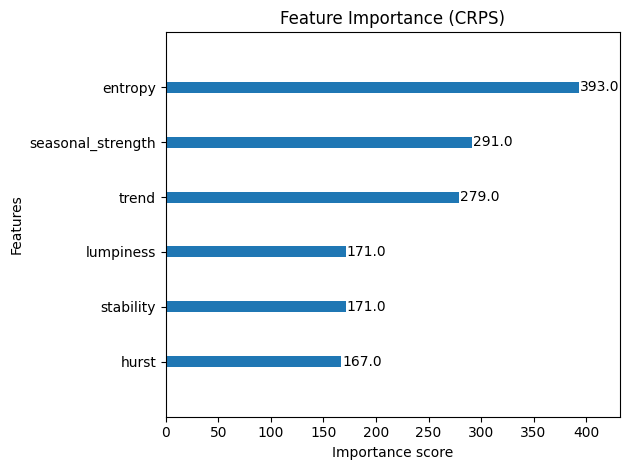

In [25]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

ax = plot_importance(estimator)
ax.set_title("Feature Importance (CRPS)")
ax.grid(False)
plt.tight_layout()

plot_dirpath = Path("plots") / "xgboost" / split_name
plot_path = plot_dirpath / "crps_importance.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=300)
plt.show()

### Inference

Now that we've trained our XGBoost tree, we can use it to estimate Chronos-Bolt's CRPS each pretraining dataset.

Load each pretraining dataset's time series features.

In [73]:
split_name = "pretrain"
input_path = Path("resources") / split_name / "features.csv"

df = pd.read_csv(input_path)
df.head()

name    term freq  prediction_length   domain     trend   
0        bull   short    H                 48   Energy  0.782879  \
1        bull  medium    H                480   Energy  0.787341   
2        bull    long    H                720   Energy  0.787341   
3  cmip6_1885   short   6H                 48  Climate  0.771910   
4  cmip6_1885  medium   6H                480  Climate  0.771910   

   seasonal_strength   entropy     hurst  stability  lumpiness  pred_crps  
0           0.643668  0.421485  0.877564   0.561245   0.861113   0.112148  
1           0.676362  0.384731  0.856679   0.561245   0.504205   0.112148  
2           0.676362  0.384731  0.864038   0.561245   0.424739   0.112148  
3           0.569295  0.394264  0.942279   0.381861   0.308085   0.112148  
4           0.601990  0.432520  0.942279   0.381861   0.308085   0.112148

Remove irrelvant columns for inference.

In [74]:
X = df[features]

X.head()

trend  seasonal_strength   entropy     hurst  stability  lumpiness
0  0.782879           0.643668  0.421485  0.877564   0.561245   0.861113
1  0.787341           0.676362  0.384731  0.856679   0.561245   0.504205
2  0.787341           0.676362  0.384731  0.864038   0.561245   0.424739
3  0.771910           0.569295  0.394264  0.942279   0.381861   0.308085
4  0.771910           0.601990  0.432520  0.942279   0.381861   0.308085

Use the trained XGBoost tree to predict Chronos-Bolt's CRPS on each pretraining dataset.

In [75]:
xgb_dirpath = Path("xgboost") / "train_test"

estimator = XGBRegressor()
estimator.load_model(xgb_dirpath / "crps.json")

y_pred = estimator.predict(X)
df["pred_crps"] = y_pred

features_path = input_path.parent / "features.csv"
df.to_csv(features_path, index=False)
df.head()

name    term freq  prediction_length   domain     trend   
0        bull   short    H                 48   Energy  0.782879  \
1        bull  medium    H                480   Energy  0.787341   
2        bull    long    H                720   Energy  0.787341   
3  cmip6_1885   short   6H                 48  Climate  0.771910   
4  cmip6_1885  medium   6H                480  Climate  0.771910   

   seasonal_strength   entropy     hurst  stability  lumpiness  pred_crps  
0           0.643668  0.421485  0.877564   0.561245   0.861113   0.112148  
1           0.676362  0.384731  0.856679   0.561245   0.504205   0.112148  
2           0.676362  0.384731  0.864038   0.561245   0.424739   0.112148  
3           0.569295  0.394264  0.942279   0.381861   0.308085   0.112148  
4           0.601990  0.432520  0.942279   0.381861   0.308085   0.112148

Split the DataFrame into quantile-based bins and count the number of datasets that belong to each
- term
- frequency
- prediction length
- domain

in all quantiles.

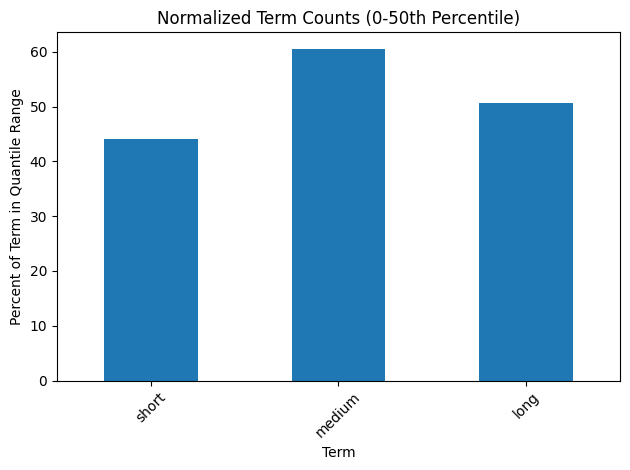

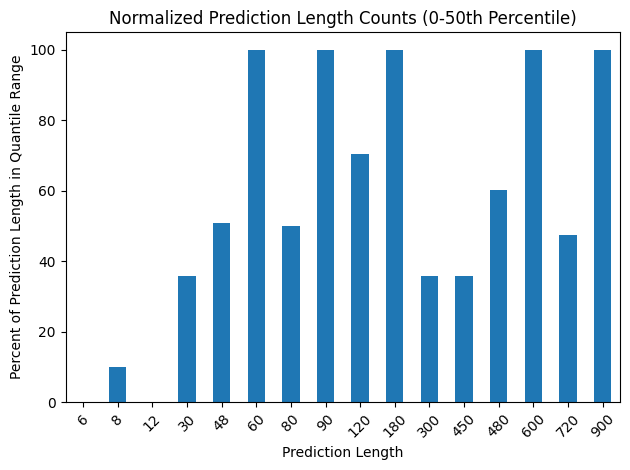

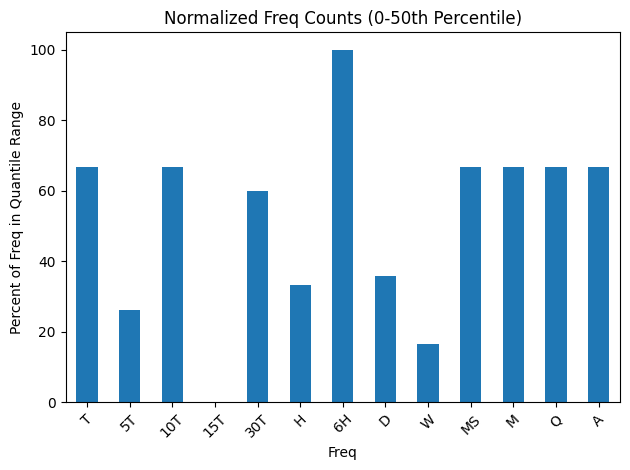

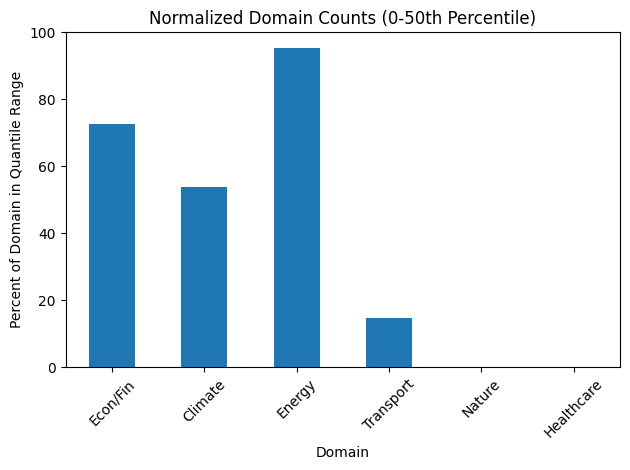

--------------------------------------------------------------------------------


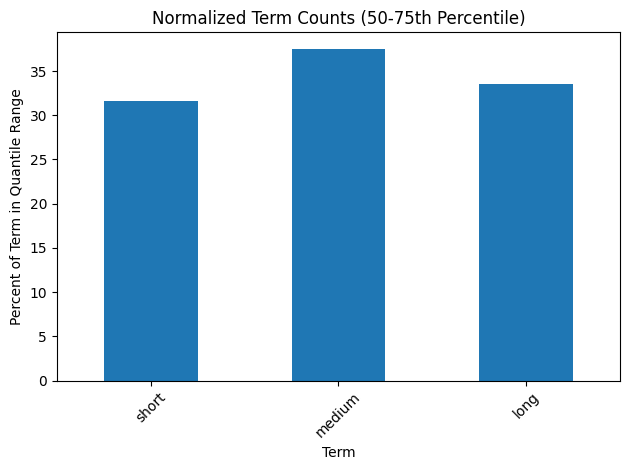

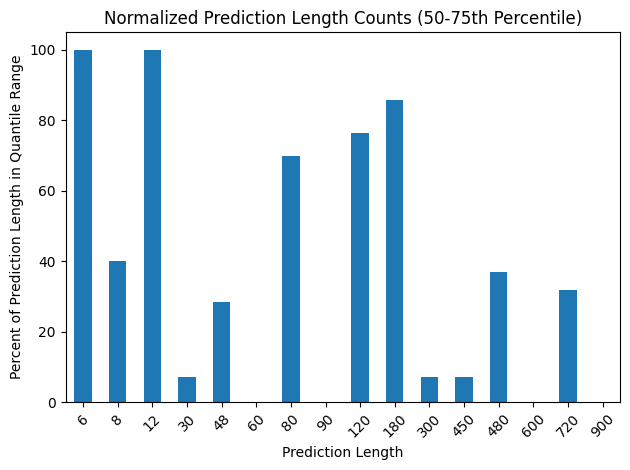

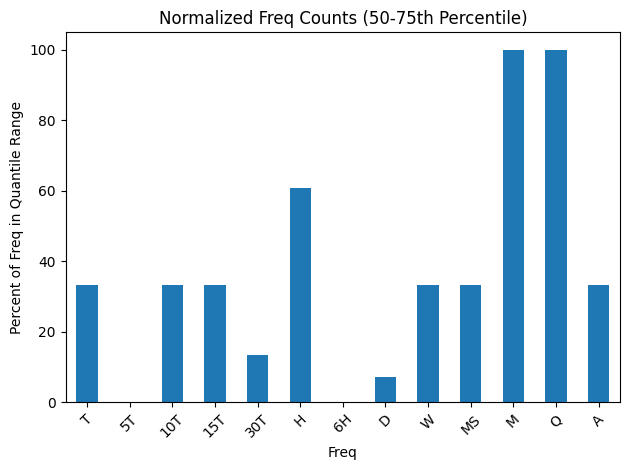

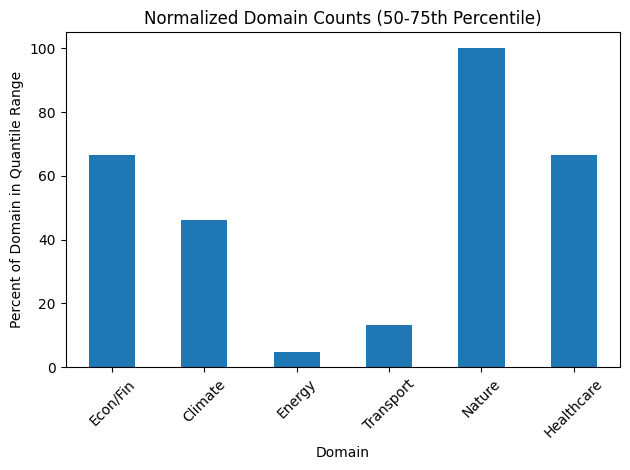

--------------------------------------------------------------------------------


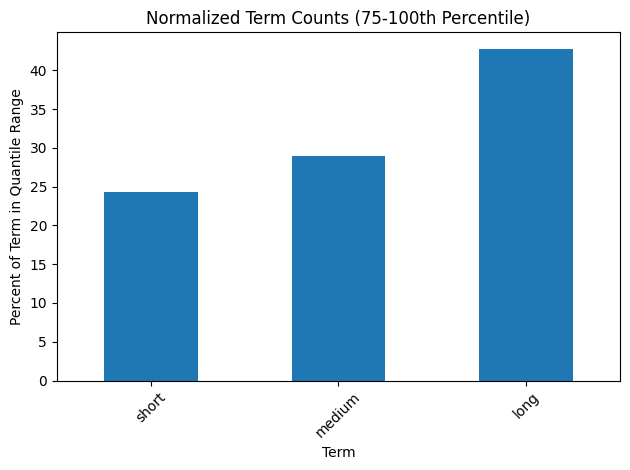

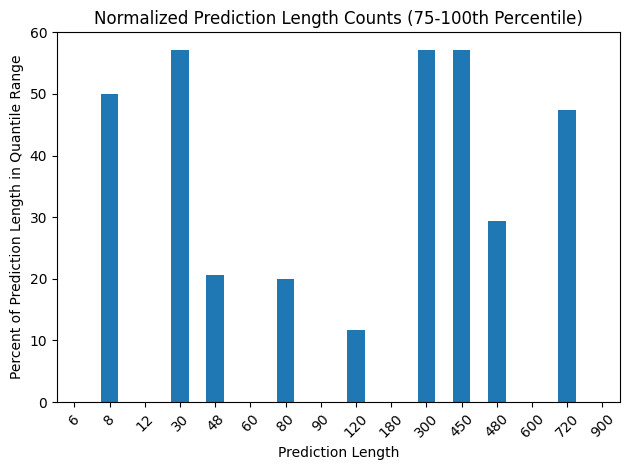

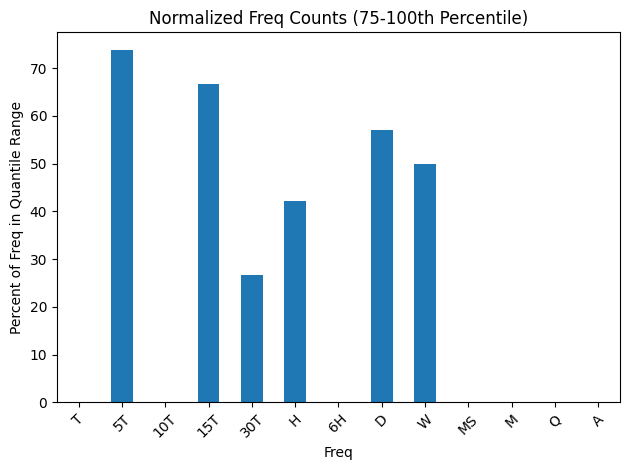

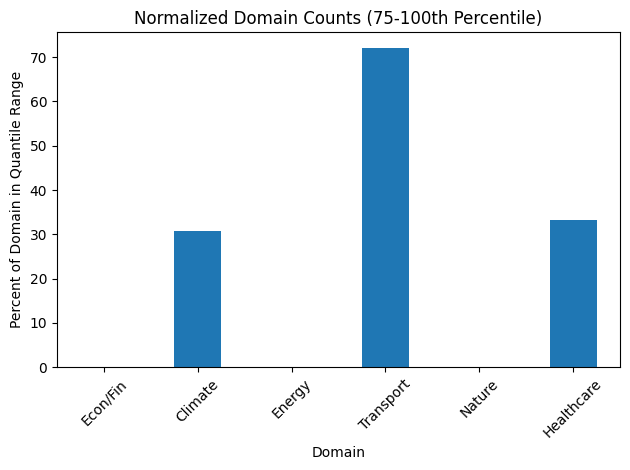

--------------------------------------------------------------------------------


In [89]:
def filter_by_quantile(df, target_col, q_start, q_end):
    """
    Returns a subset of the DataFrame where the target_col values
    fall between the q_start and q_end quantiles.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): Column name to compute quantiles on.
        q_start (float): Lower quantile (e.g., 0.25).
        q_end (float): Upper quantile (e.g., 0.5).

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    q_lo = df[target_col].quantile(q_start)
    q_hi = df[target_col].quantile(q_end)
    return df[(df[target_col] >= q_lo) & (df[target_col] <= q_hi)]


def plot_histogram(df, target_col, value_col, q_start, q_end):
    """
    Plots a histogram of the number of datasets belonging to each category in
    value_col for rows in the target_col quantile range [q_start, q_end).

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): Name of the numeric column to compute quantiles on.
        value_col (str): Name of the column whose counts will be plotted.
        q_start (float): Lower quantile bound (e.g. 0.25).
        q_end (float): Upper quantile bound (e.g. 0.5).
    """
    subset_df = filter_by_quantile(df, target_col, q_start, q_end)

    # Counts in the quantile range
    counts = subset_df[value_col].value_counts().sort_index()

    # Total counts for normalization
    total_counts = df[value_col].value_counts()

    # Normalize (percent of value_col category in this quantile range)
    percentages = (counts / total_counts).fillna(0).sort_index() * 100

    if value_col == "term":
        custom_order = ["short", "medium", "long"]
    elif value_col == "freq":
        custom_order = [
            "S",
            "5S",
            "10S",
            "15S",
            "30S",  # Secondly
            "T",
            "5T",
            "10T",
            "15T",
            "30T",  # Minutely (T = min)
            "H",
            "6H",
            "12H",  # Hourly
            "D",
            "W",  # Daily, Weekly
            "MS",
            "M",  # Month Start, Month End
            "Q",
            "A",  # Quarterly, Annual
        ]
    elif value_col == "domain":
        custom_order = [
            "Econ/Fin",
            "Climate",
            "Energy",
            "Transport",
            "Nature",
            "Healthcare",
        ]
    else:
        custom_order = None

    if custom_order is not None:
        ordered_index = [val for val in custom_order if val in percentages.index]
        percentages = percentages.reindex(ordered_index)

    percentages.plot(kind="bar")
    col_name = value_col.replace("_", " ").title()
    plt.title(
        f"Normalized {col_name} Counts ({int(q_start*100)}-{int(q_end*100)}th Percentile)"
    )
    plt.xlabel(col_name)
    plt.ylabel(f"Percent of {col_name} in Quantile Range")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


num_bins = 4
num_edges = num_bins + 1
quantile_edges = np.linspace(0, 1, num_edges).tolist()

for i in range(len(quantile_edges) - 1):
    if i == 1:
        continue

    q_start, q_end = quantile_edges[i], quantile_edges[i + 1]

    if i == 0:
        q_end = 0.5

    columns = ["term", "prediction_length", "freq", "domain"]
    for col in columns:
        plot_histogram(
            df=df,
            target_col="pred_crps",
            value_col=col,
            q_start=q_start,
            q_end=q_end,
        )

    print("-" * 80)